In [1]:
import platform
import datetime as dt
import itertools
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import AnchoredText
import seaborn
from IPython.display import display

seaborn.set(palette='pastel')
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

print("python", platform.python_version())
print("pandas", pd.__version__)

python 3.8.2
pandas 1.0.3


## data catalog

`dict` containing datasets used throughout notebook.

The simple structure is: `<source>.data.[<dataset>]`. Note that each dataframe is "versioned" to the date its upstream raw data was downloaded.

In [2]:
CATALOG = {
    'csse': {
        'name': "CSSE COVID-19 Dataset",
        'description': "csse_covid_19_time_series",
        'organization': "Johns Hopkins CSSE",
        'url': "https://github.com/CSSEGISandData/COVID-19",
        'data': {},
        'timestamp': None,
    },
    'ontology': {
        'data': {}
    }
}

In [3]:
def catalogls(cat=None):
    """Pretty print the data catalog."""
    cat = cat or CATALOG
    tab = '    '
    print("DATA CATALOG")
    for name, obj in cat.items():
        print(f"{name}:")
        meta = ['name', 'description', 'organization', 'url']
        if any(x in obj for x in meta):
            for p in meta:
                print(f"{tab}{p}: {obj[p]}")
        print(f"{tab}data:")
        for n, df in obj['data'].items():
            print(f"{tab}{tab}{n}", end='')
            print(f" - {obj['timestamp']}") if 'timestamp' in obj else print("")
# catalogls()

## download raw data
Create `DataFrame`s directly from source data.

In [4]:
repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19'
branch = 'master'
folder = 'csse_covid_19_data/csse_covid_19_time_series'

# TODO: these files deprecated as of 2020-03-23
CATALOG['csse']['data'].update({
    'raw.confirmed':
        pd.read_csv(f'{repo}/{branch}/{folder}/time_series_19-covid-Confirmed.csv'),
    'raw.deaths':
        pd.read_csv(f'{repo}/{branch}/{folder}/time_series_19-covid-Deaths.csv'),
    'raw.recovered':
        pd.read_csv(f'{repo}/{branch}/{folder}/time_series_19-covid-Recovered.csv'),
})

# timestamp = dt.datetime.now()
timestamp = max(CATALOG['csse']['data']['raw.confirmed'].columns[4:].map(pd.to_datetime))
CATALOG['csse']['timestamp'] = timestamp.strftime("%Y-%m-%d %H:%M:%S")

# preview
for name, df in CATALOG['csse']['data'].items():
    display(f"preview: {name}", df.tail(3))

catalogls()

'preview: raw.confirmed'

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
484,NaN,Mozambique,-18.6657,35.5296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
485,NaN,Syria,34.8021,38.9968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
486,NaN,Timor-Leste,-8.8742,125.7275,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


'preview: raw.deaths'

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
484,NaN,Mozambique,-18.6657,35.5296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
485,NaN,Syria,34.8021,38.9968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
486,NaN,Timor-Leste,-8.8742,125.7275,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


'preview: raw.recovered'

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
484,NaN,Mozambique,-18.6657,35.5296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
485,NaN,Syria,34.8021,38.9968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
486,NaN,Timor-Leste,-8.8742,125.7275,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


DATA CATALOG
csse:
    name: CSSE COVID-19 Dataset
    description: csse_covid_19_time_series
    organization: Johns Hopkins CSSE
    url: https://github.com/CSSEGISandData/COVID-19
    data:
        raw.confirmed - 2020-03-22 00:00:00
        raw.deaths - 2020-03-22 00:00:00
        raw.recovered - 2020-03-22 00:00:00
ontology:
    data:


## clean data

- melt dates to restructure data into a stable schema we can create timeseries off
- handle country-specific inconsistencies, e.g. resolve county vs state level numbers for the US

In [5]:
def get_state_resolution_table(s):
    states = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Guam': 'GU',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Northern Mariana Islands':'MP',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Palau': 'PW',
        'Pennsylvania': 'PA',
        'Puerto Rico': 'PR',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virgin Islands': 'VI',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY',
    }
    
    s.name = 'raw'
    df = (
        s
        .drop_duplicates()
        .to_frame()
        .sort_values('raw')
        .reset_index()
    )

    df['_clean'] = df['raw'].map(lambda s: str(s).strip().replace('.', ''))

    # "Alabama" -> "AL"
    # df['_abbrv'] = df['_clean'].map(states)

    # "County, AL" -> "AL"
    df['_extracted'] = df['_clean'].str.extract(r', (\w{2})$')
    df['_extracted'] = df['_extracted'].map(dict(map(reversed, states.items())))

    # coalesce to resolved property
    # df['resolved'] = df['_abbrv'].fillna(df['_extracted']).fillna(df['_clean'])
    df['resolved'] = df['_extracted'].fillna(df['_clean'])
    return df.set_index('raw')['resolved']


def clean_csse(df):

    # drop lat/long since resolving county -> state
    df = df.copy().drop(['Lat', 'Long'], axis=1)

    df = df.melt(
        id_vars=[
            'Province/State',
            'Country/Region',
        ],
        var_name='date',
        value_name='value'
    )

    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.strftime('%Y-%m-%d')
    df = df.rename(columns={
        'Province/State': 'state',
        'Country/Region': 'country',
    })

    # normalize Province/State column for the US
    # up until 2020-03-08 numbers were mixed, at the county/state level
    # 2020-03-09 onwards numbers are at the state level
    row_index = df['country'] == 'US'
    lookup = get_state_resolution_table(df.loc[row_index, 'state'])
    df.loc[row_index, 'state'] = df.loc[row_index, 'state'].map(lookup)

    return (
        df
        .assign(state=df['state'].fillna(df['country']))
        .groupby(['date', 'day', 'country', 'state'])
        .sum()
        .reset_index()
    )


In [6]:
# clean and preview
for ds in ['confirmed', 'deaths', 'recovered']:
    df = clean_csse(CATALOG['csse']['data'][f"raw.{ds}"])
    CATALOG['csse']['data'].update({f"clean.{ds}": df})
    display(f"preview: clean.{ds}", df.tail(3))
catalogls()

'preview: clean.confirmed'

,date,day,country,state,value
18053,2020-03-22,2020-03-22,Vietnam,Vietnam,113
18054,2020-03-22,2020-03-22,Zambia,Zambia,3
18055,2020-03-22,2020-03-22,Zimbabwe,Zimbabwe,3


'preview: clean.deaths'

,date,day,country,state,value
18053,2020-03-22,2020-03-22,Vietnam,Vietnam,0
18054,2020-03-22,2020-03-22,Zambia,Zambia,0
18055,2020-03-22,2020-03-22,Zimbabwe,Zimbabwe,0


'preview: clean.recovered'

,date,day,country,state,value
18053,2020-03-22,2020-03-22,Vietnam,Vietnam,17
18054,2020-03-22,2020-03-22,Zambia,Zambia,0
18055,2020-03-22,2020-03-22,Zimbabwe,Zimbabwe,0


DATA CATALOG
csse:
    name: CSSE COVID-19 Dataset
    description: csse_covid_19_time_series
    organization: Johns Hopkins CSSE
    url: https://github.com/CSSEGISandData/COVID-19
    data:
        raw.confirmed - 2020-03-22 00:00:00
        raw.deaths - 2020-03-22 00:00:00
        raw.recovered - 2020-03-22 00:00:00
        clean.confirmed - 2020-03-22 00:00:00
        clean.deaths - 2020-03-22 00:00:00
        clean.recovered - 2020-03-22 00:00:00
ontology:
    data:


### combined
Create master `DataFrame`s with timeseries for `confirmed`, `deaths`, `recovered`, aggregated at `country` and `state`.

In [7]:
def patch_spot_errors(df):
    """inline fixes"""

    def row_index(day, country, state=None):
        return (
            (df['day'] == day)
            & (df['country'] == country)
            & (df['state'] == (state or country))
        )
    
    # 2020-03-12
    # 2020-03-15
    # source: https://www.worldometers.info/coronavirus/
    series = 'cases'
    df.loc[row_index('2020-03-12', 'Italy'), series] = 15113
    df.loc[row_index('2020-03-12', 'France'), series] = 2876
    df.loc[row_index('2020-03-12', 'Spain'), series] = 3146
    df.loc[row_index('2020-03-12', 'Germany'), series] = 2745
    df.loc[row_index('2020-03-12', 'United Kingdom'), series] = 590
    
    df.loc[row_index('2020-03-15', 'France'), series] = 5423
    df.loc[row_index('2020-03-15', 'United Kingdom'), series] = 1391

    series = 'deaths'
    df.loc[row_index('2020-03-12', 'Italy'), series] = 1016
    df.loc[row_index('2020-03-12', 'France'), series] = 61
    df.loc[row_index('2020-03-12', 'Spain'), series] = 86
    df.loc[row_index('2020-03-12', 'Germany'), series] = 6
    df.loc[row_index('2020-03-12', 'United Kingdom'), series] = 10
    
    df.loc[row_index('2020-03-15', 'France'), series] = 127
    df.loc[row_index('2020-03-15', 'United Kingdom'), series] = 35
    
    series = 'recovered'
    df.loc[row_index('2020-03-12', 'Italy'), series] = 1258
    df.loc[row_index('2020-03-12', 'Spain'), series] = 189

    return df


def _normalize(df, name):
    return (
        df
        .rename(columns={'value': name})
        .set_index(['date', 'day', 'country', 'state'])
    )

dfs = [
    CATALOG['csse']['data']['clean.confirmed'],
    CATALOG['csse']['data']['clean.deaths'],
    CATALOG['csse']['data']['clean.recovered'],
]

# combine
dfs = map(lambda x: _normalize(*x), zip(dfs, ['cases', 'deaths', 'recovered']))
df = pd.concat(dfs, axis=1, sort=True).reset_index()

# fix errors

# fill in estimated data to Hubei
# useful for offset plots which origin from cases >= 100 and deaths >= 10
# values estimated using Excel's GROWTH function, using the first 10 values
china_patch = pd.DataFrame(
    [('2020-01-18', 'China', 'Hubei', 96, 4, np.nan),
     ('2020-01-19', 'China', 'Hubei', 132, 6, np.nan),
     ('2020-01-20', 'China', 'Hubei', 182, 8, np.nan),
     ('2020-01-21', 'China', 'Hubei', 250, 11, np.nan),
    ],
    columns=['day', 'country', 'state', 'cases', 'deaths', 'recovered'])
china_patch['date'] = pd.to_datetime(china_patch['day'])

df = pd.concat([df, china_patch]).sort_values('date').reset_index(drop=True)
df = patch_spot_errors(df)

CATALOG['csse']['data']['combined'] = df
display("preview", df.loc[df['state'] == 'Hubei'].head(10))
# catalogls()

'preview'

,date,day,country,state,cases,deaths,recovered
0,2020-01-18,2020-01-18,China,Hubei,96,4,NaN
1,2020-01-19,2020-01-19,China,Hubei,132,6,NaN
2,2020-01-20,2020-01-20,China,Hubei,182,8,NaN
3,2020-01-21,2020-01-21,China,Hubei,250,11,NaN
176,2020-01-22,2020-01-22,China,Hubei,444,17,28.0
472,2020-01-23,2020-01-23,China,Hubei,444,17,28.0
768,2020-01-24,2020-01-24,China,Hubei,549,24,31.0
1063,2020-01-25,2020-01-25,China,Hubei,761,40,32.0
1361,2020-01-26,2020-01-26,China,Hubei,1058,52,42.0
1655,2020-01-27,2020-01-27,China,Hubei,1423,76,45.0


## ontology

### by date

In [8]:
METRICS = ['cases', 'deaths', 'recovered']
LIMITS = {'cases': 100, 'deaths': 10, 'recovered': 10}


def with_cases_active(df):
    df['cases_active'] = df['cases'] - df['deaths'] - df['recovered']
    return df


def with_cfr(df):
    df['cfr'] = 100 * (df['deaths'] / df['cases'])
    return df


def with_diff(df):
    agg_level = ['country', 'state']
    if 'metric' in df.columns:
        agg_level += ['metric']
    df[[f"{m}_new" for m in METRICS]] = (
        df
        .sort_values('date')
        .groupby(agg_level)[METRICS]
        .diff()
    )
    return df


def with_pct_change(df):
    agg_level = ['country', 'state']
    if 'metric' in df.columns:
        agg_level += ['metric']
    df[[f"{m}_pct_change" for m in METRICS]] = 100 * (
        df
        .sort_values('date')
        .groupby(agg_level)[METRICS]
        .pct_change()
    )
    return df


In [9]:
df = CATALOG['csse']['data']['combined'].copy()

df = (
    df
    .pipe(with_cases_active)
    .pipe(with_cfr)
    .pipe(with_diff)
    .pipe(with_pct_change)
)

CATALOG['ontology']['data']['metrics_by_date'] = df
display("preview", df[df['country'] == 'Italy'].sort_values('date').tail())

'preview'

,date,day,country,state,cases,deaths,recovered,cases_active,cfr,cases_new,deaths_new,recovered_new,cases_pct_change,deaths_pct_change,recovered_pct_change
16826,2020-03-18,2020-03-18,Italy,Italy,35713,2978,4025.0,28710.0,8.338700,4207.0,475.0,1084.0,13.353012,18.977227,36.858211
17123,2020-03-19,2020-03-19,Italy,Italy,41035,3405,4440.0,33190.0,8.297795,5322.0,427.0,415.0,14.902136,14.338482,10.310559
17418,2020-03-20,2020-03-20,Italy,Italy,47021,4032,4440.0,38549.0,8.574892,5986.0,627.0,0.0,14.587547,18.414097,0.000000
17716,2020-03-21,2020-03-21,Italy,Italy,53578,4825,6072.0,42681.0,9.005562,6557.0,793.0,1632.0,13.944833,19.667659,36.756757
18010,2020-03-22,2020-03-22,Italy,Italy,59138,5476,7024.0,46638.0,9.259698,5560.0,651.0,952.0,10.377394,13.492228,15.678524


### by offset day

Create `DataFrame` indexed by `offset`: an integer for each day since a certain threshold cases or deaths was reached.

`DataFrame` contains multiple `offset` indexes, identified by the categorical field `metric`.

In [10]:
def with_offset(df, index, limit=100):
    col = f"{index}_offset"
    agg_level = ['country', 'state']
    if 'metric' in df.columns:
        agg_level += ['metric']
    df[col] = (
        df
        .loc[df[index] >= limit]
        .sort_values(['country', 'state', 'date'])
        .groupby(agg_level)[index]
        .cumcount()
    )
    return df


def reindex_offset(df, index):
    if not 'metric' in df.columns:
        df['metric'] = index
    df = (
        df
        .dropna(subset=[index])
        .set_index([index, 'metric'])
        .reset_index()
        .rename(columns={index: 'offset'})
    )
    return df


df = CATALOG['csse']['data']['combined'].copy()
df = (
    df
    .pipe(with_offset, 'cases', 100)
    .pipe(with_offset, 'deaths', 10)
    .pipe(with_offset, 'recovered', 10)
    .melt(
        ['date', 'day', 'country', 'state', *METRICS],
        ['cases_offset', 'deaths_offset', 'recovered_offset'],
        'metric',
        'offset',
    )
    .replace(r"_offset$", '', regex=True)
    .pipe(reindex_offset, 'offset')
    .pipe(with_cases_active)
    .pipe(with_cfr)
    .pipe(with_diff)
    .pipe(with_pct_change)
)

CATALOG['ontology']['data']['metrics_by_offset'] = df
df.loc[df['state'] == 'California'].tail()

,offset,metric,date,day,country,state,cases,deaths,recovered,cases_active,cfr,cases_new,deaths_new,recovered_new,cases_pct_change,deaths_pct_change,recovered_pct_change
2508,1.0,deaths,2020-03-18,2020-03-18,US,California,751,13,0.0,738.0,1.731025,53.0,1.0,-6.0,7.593123,8.333333,-100.0
2532,2.0,deaths,2020-03-19,2020-03-19,US,California,952,18,0.0,934.0,1.890756,201.0,5.0,0.0,26.764314,38.461538,NaN
2557,3.0,deaths,2020-03-20,2020-03-20,US,California,1177,23,0.0,1154.0,1.954121,225.0,5.0,0.0,23.634454,27.777778,NaN
2585,4.0,deaths,2020-03-21,2020-03-21,US,California,1364,24,0.0,1340.0,1.759531,187.0,1.0,0.0,15.887850,4.347826,NaN
2620,5.0,deaths,2020-03-22,2020-03-22,US,California,1642,30,0.0,1612.0,1.827040,278.0,6.0,0.0,20.381232,25.000000,NaN


## summary tables

In [11]:
df = CATALOG['ontology']['data']['metrics_by_date'].copy()

# filter to latest date
df = df.loc[(df['date'] == max(df['date'])) & (df['cases'] > 0)].drop(['date', 'day'], axis=1)

metrics = ['cases', 'cases_new', 'deaths', 'deaths_new', 'recovered', 'cases_active']
agg_level = [
    'country',
    'state',
]

df = (
    df
    .groupby(agg_level)
    .agg({metric: sum for metric in metrics})
    .assign(
        cases_pct_change=lambda df: 100 * (df['cases_new'] / (df['cases'] - df['cases_new'])),
        deaths_pct_change=lambda df: 100 * (df['deaths_new'] / (df['deaths'] - df['deaths_new']))
    )
    .query('cases >= 100')  # only include regions with significant impact
    .sort_values('cases', ascending=False)
    .reset_index()
    [agg_level + [
        'cases', 'cases_new', 'cases_pct_change',
        'deaths', 'deaths_new', 'deaths_pct_change',
        'recovered', 'cases_active']]
)

# combine country+state
if 'state' in agg_level:
    mask = (df['country'] == df['state'])
    df.loc[mask, 'state'] = None
    df['country'] = df[['country', 'state']].agg(lambda s: ', '.join(filter(None, s)), axis=1)
    df = df.drop('state', axis=1)

# simplify row index
df = (
    df
    .rename(columns={'country': 'region'})
    .reset_index(drop=False)
    .set_index(['index', 'region'])
)

def prettify(df):
    for m in metrics:
        df[m] = df[m].map(lambda x: f"{x:,.0f}")
    for m in ['cases_pct_change', 'deaths_pct_change']:
        df[m] = df[m].map(lambda x: f"{x:,.1f}")
    return df


display(
    "regions with most cases",
    prettify(df.sort_values('cases', ascending=False)).head(10)
)
display(
    "regions fastest growing, regions with 500 or more new cases/day",
    prettify(df.query('cases_new > 500')
               .sort_values('cases_pct_change', ascending=False).head(10))
)

'regions with most cases'

,,cases,cases_new,cases_pct_change,deaths,deaths_new,deaths_pct_change,recovered,cases_active
index,region,,,,,,,,
0,"China, Hubei","67,800",0,0.0,"3,144",5,0.2,"59,433","5,223"
1,Italy,"59,138","5,560",10.4,"5,476",651,13.5,"7,024","46,638"
2,Spain,"28,768","3,394",13.4,"1,772",397,28.9,"2,575","24,421"
3,Germany,"24,873","2,660",12.0,94,10,11.9,266,"24,513"
4,Iran,"21,638","1,028",5.0,"1,685",129,8.3,"7,931","12,022"
5,France,"16,018","1,736",12.2,674,112,19.9,"2,200","13,144"
6,"US, New York","15,793","4,083",34.9,117,57,95.0,0,"15,676"
7,"Korea, South","8,897",98,1.1,104,2,2.0,"2,909","5,884"
8,Switzerland,"7,245",670,10.2,98,23,30.7,131,"7,016"


'regions fastest growing, regions with 500 or more new cases/day'

,,cases,cases_new,cases_pct_change,deaths,deaths_new,deaths_pct_change,recovered,cases_active
index,region,,,,,,,,
25,Turkey,"1,236",566,84.5,30,21,233.3,0,"1,206"
19,Brazil,"1,593",572,56.0,25,10,66.7,2,"1,566"
16,"US, New Jersey","1,914",587,44.2,20,4,25.0,0,"1,894"
6,"US, New York","15,793","4,083",34.9,117,57,95.0,0,"15,676"
11,Belgium,"3,401",586,20.8,75,8,11.9,263,"3,063"
10,Netherlands,"4,204",573,15.8,179,43,31.6,2,"4,023"
2,Spain,"28,768","3,394",13.4,"1,772",397,28.9,"2,575","24,421"
9,United Kingdom,"5,683",665,13.3,281,48,20.6,65,"5,337"
5,France,"16,018","1,736",12.2,674,112,19.9,"2,200","13,144"


## timeseries

### absolute time

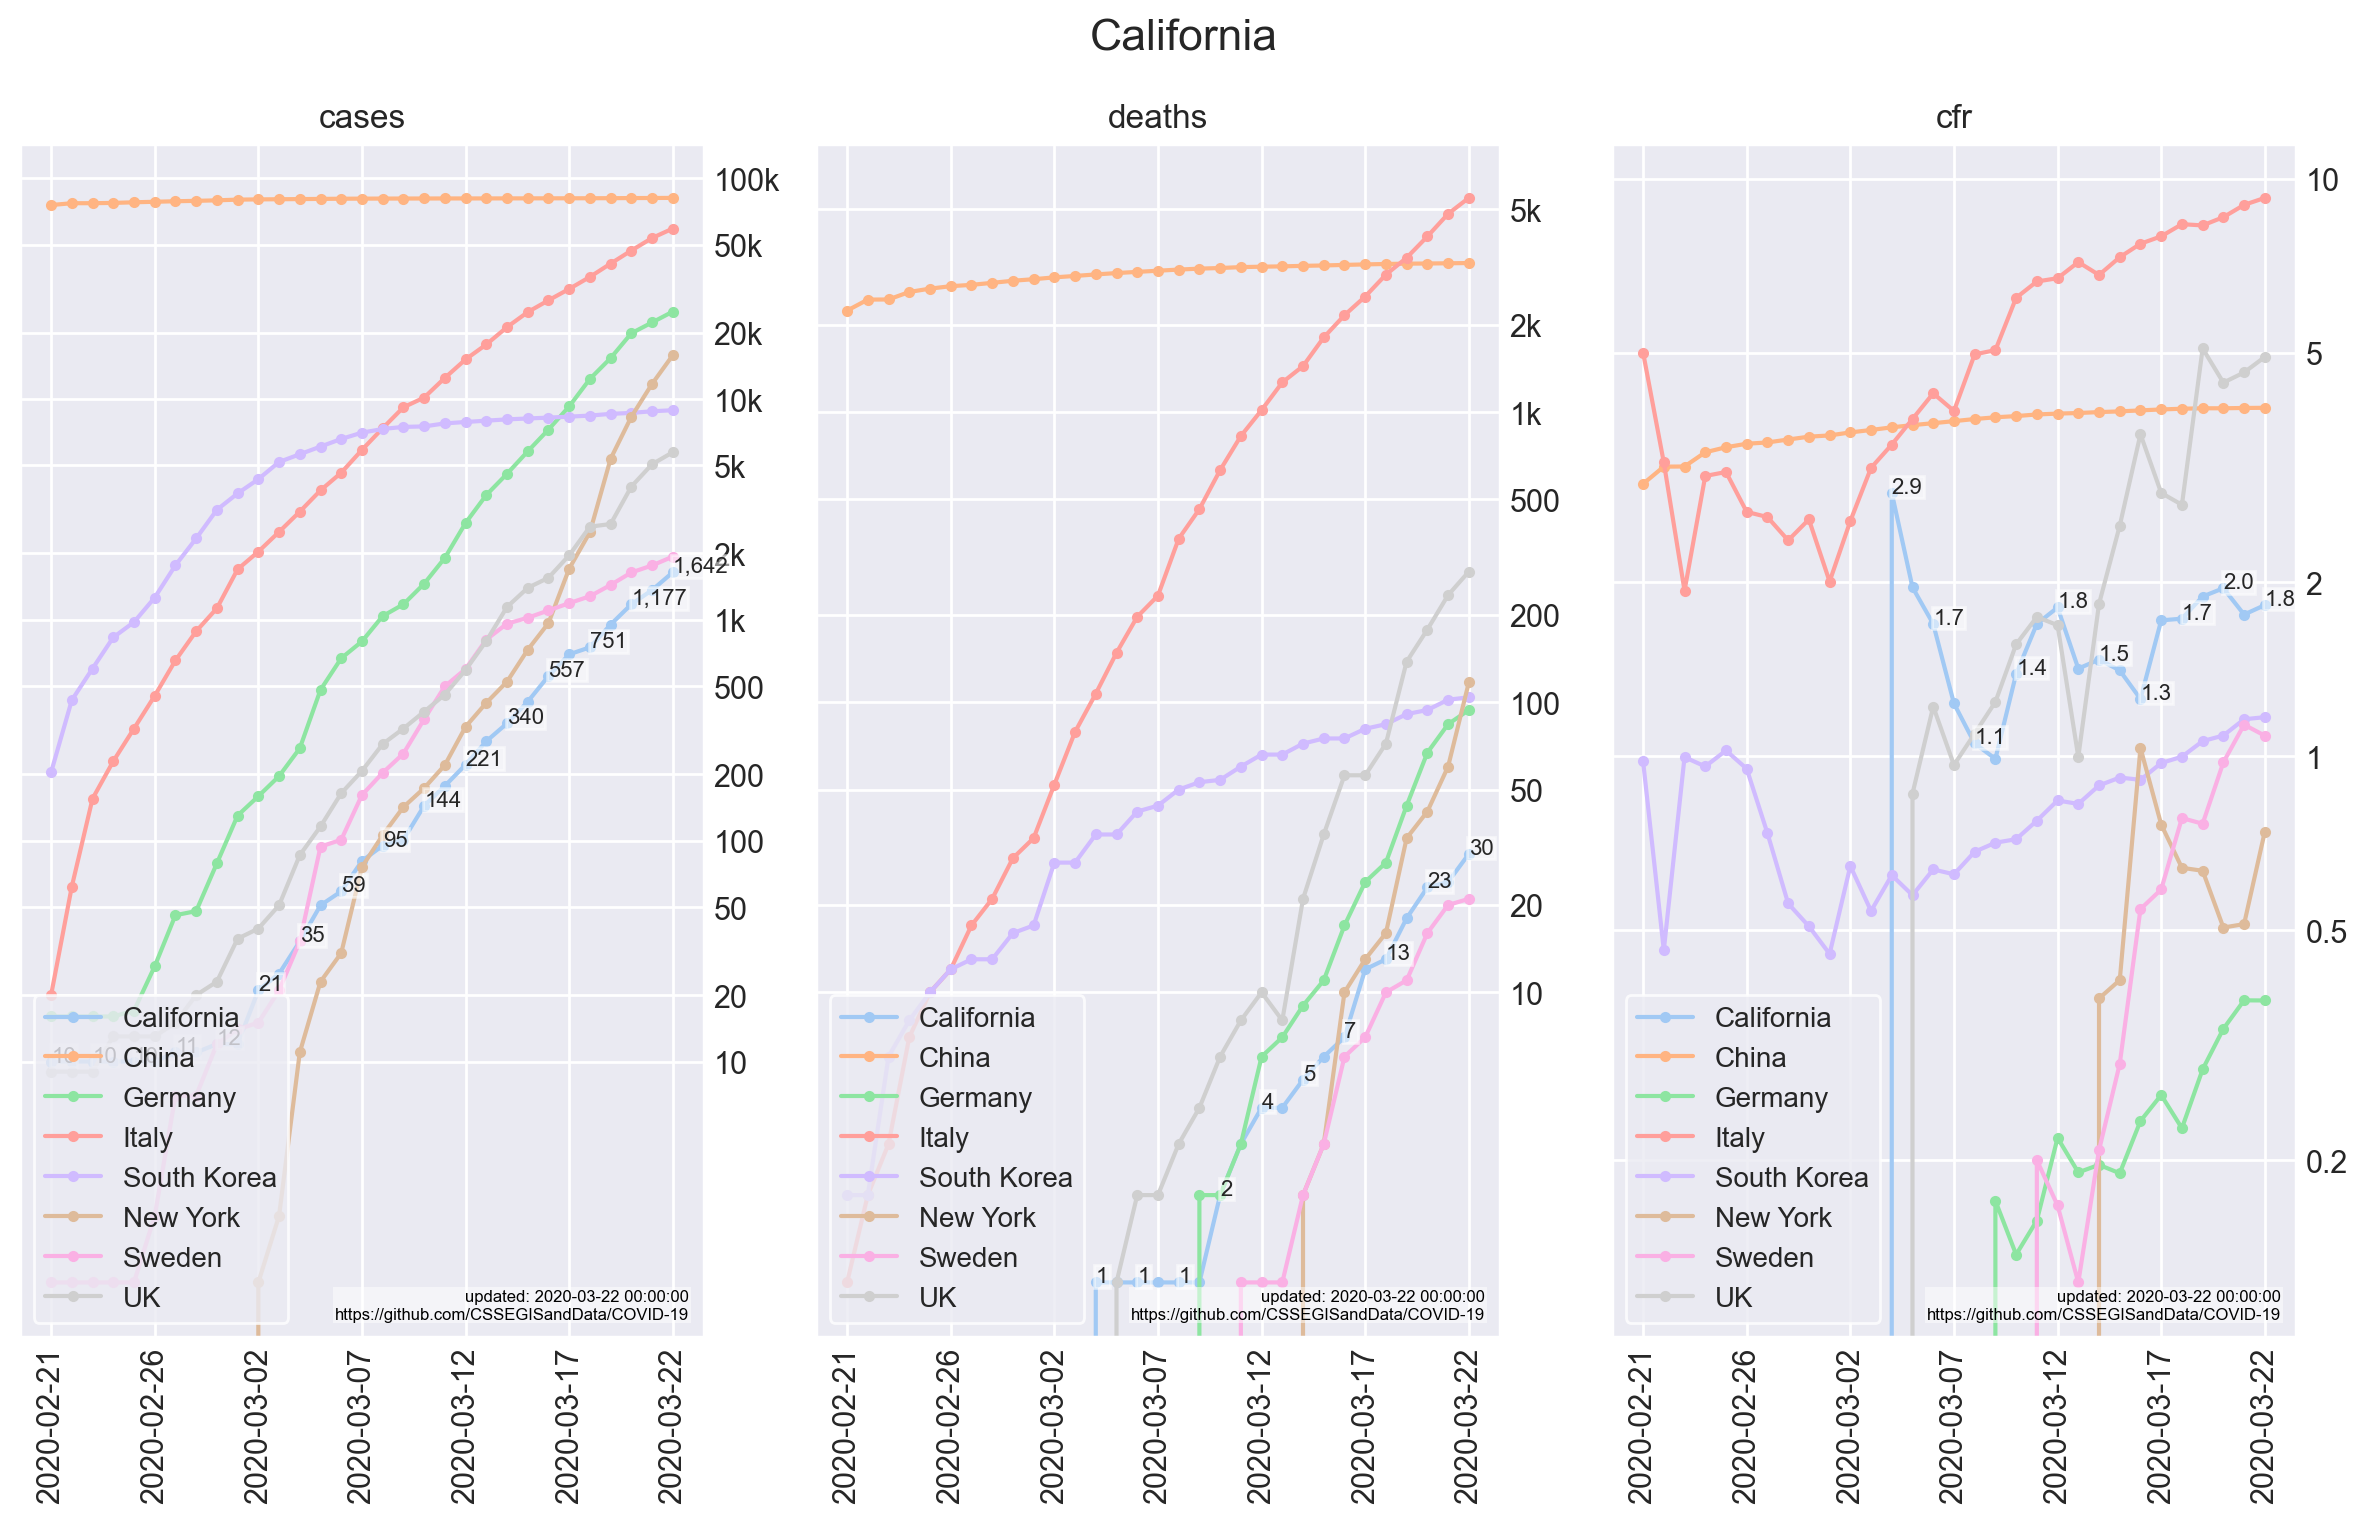

In [12]:
def get_timeseries(df, index, series, country=None, state=None, rollup_states=True):
    df = df.copy()

    if isinstance(country, str):
        country = [country]
    if isinstance(state, str):
        state = [state]

    df_country = df.loc[df['country'].isin(country)] if country else pd.DataFrame()

    if country and rollup_states:
        df_country = (
            df_country
            .groupby(['date', 'day', 'country'])
            .sum()
            .reset_index()
            .assign(state=lambda x: x['country'])
        )
        # recompute aggregate metrics
        df_country = with_cfr(df_country)
        df_country = with_diff(df_country)
        df_country = with_pct_change(df_country)

    df_state = df.loc[df['state'].isin(state)] if state else pd.DataFrame()
    df = pd.concat([df_country, df_state], sort=True)

    df['region'] = df['state'].fillna(df['country'])#.str.lower()
    df = df.pivot(index=index, columns='region', values=series)
    return df


def configure_yaxis(ax):
    
    def formatter(number, pos=None):
        """Convert a number into a human readable format."""
        magnitude = 0
        while abs(number) >= 1000:
            magnitude += 1
            number /= 1000.0
        decimals = 1 if number < 1 else 0
        return f"{number:,.{decimals}f}{['', 'k', 'M', 'B'][magnitude]}"

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
    
    # human readable y scale ticks
    ymin, ymax = ax.get_ylim()
    ticks = map(lambda x: (x, 2 * x, 5 * x), ax.get_yticks())
    ticks = itertools.chain(*ticks)
    ticks = list(filter(lambda y: (y > ymin) & (y < ymax), ticks))[1:]
    if len(ticks) > 10:
        ticks = ticks[2:]
    ax.set_yticks(ticks)


def plot(countries, states, plots, highlight='Italy', dpi=100):

    days = 31
    from_date = (dt.datetime.now() - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    
    cols = len(plots)
    fig, axs = plt.subplots(1, cols, figsize=(cols * 4, 8), dpi=dpi, facecolor='white')
    
    for i, t in enumerate(plots.items()):
        series, df = t
        ax = axs[i] if cols > 1 else axs

        ts = get_timeseries(
            df,
            index='day',
            series=series,
            country=countries,
            state=states,
        )[from_date:]

        ts = ts.rename(columns={
            "United Kingdom": "UK",
            "Korea, South": "South Korea",
        })

        ax = ts.plot(title=series, legend=True, marker='.', ax=ax)
        
        # y-axis
        ax.set_yscale('log', basey=10)
        configure_yaxis(ax)
        ax.yaxis.tick_right()
        ax.tick_params(axis='both', which='both',length=0)

        # x-axis
        ax.xaxis.label.set_visible(False)
        ax.set_xticks(range(0, days, 5))
        ax.set_xticklabels(ts.index.values[::5])
        plt.setp(ax.get_xticklabels(), rotation=90)
        
        # value labels
        values = ts[highlight].values
        for i, v in enumerate(values):
            # every 2 label, ensuring most recent value included
            if ((i % 2) != (len(values) % 2)) & (v > 0):
                frmt = f'{v:,.1f}' if series in ['cfr'] else f'{v:,.0f}'
                bbox = dict(pad=0.5, facecolor='white', alpha=0.5)
                ax.text(i, v, frmt, ha='left', fontsize=8, bbox=bbox)

        # info text box
        text = f"updated: {CATALOG['csse']['timestamp']}\n{CATALOG['csse']['url']}"
        props = dict(color='black', fontsize=6, multialignment='right')
        box = AnchoredText(text, loc=4, frameon=True, pad=0.1, borderpad=0.8, prop=props)
        plt.setp(box.patch, facecolor='white', alpha=0.5, linewidth=0)
        ax.add_artist(box)
        
        # legend
        plt.sca(ax)
        leg = plt.legend(loc=3, prop={'size':10})
        leg.get_frame().set_edgecolor('white')
        leg.get_frame().set_linewidth(1.0)

    if cols > 1:
        fig.suptitle(highlight, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])


eu5 = ['Italy', 'United Kingdom', 'Germany', 'Spain', 'France']
nordics = ['Sweden', 'Denmark', 'Norway', 'Finland']
asia = ['China', 'Korea, South', 'Singapore', 'Japan']
us = ['California', 'New York', 'Washington', 'New Jersey', 'Illinois']

# works best when picking 4-8 countries/states
df = CATALOG['ontology']['data']['metrics_by_date']

plot(
    countries=eu5[:3] + nordics[:1] + asia[:2],
    states=us[:2],
    plots={
        'cases': df,
        'deaths': df,
        'cfr': df,
    },
    **dict(highlight='California', dpi=200),
)

## relative time

c.f. https://www.ft.com/coronavirus-latest

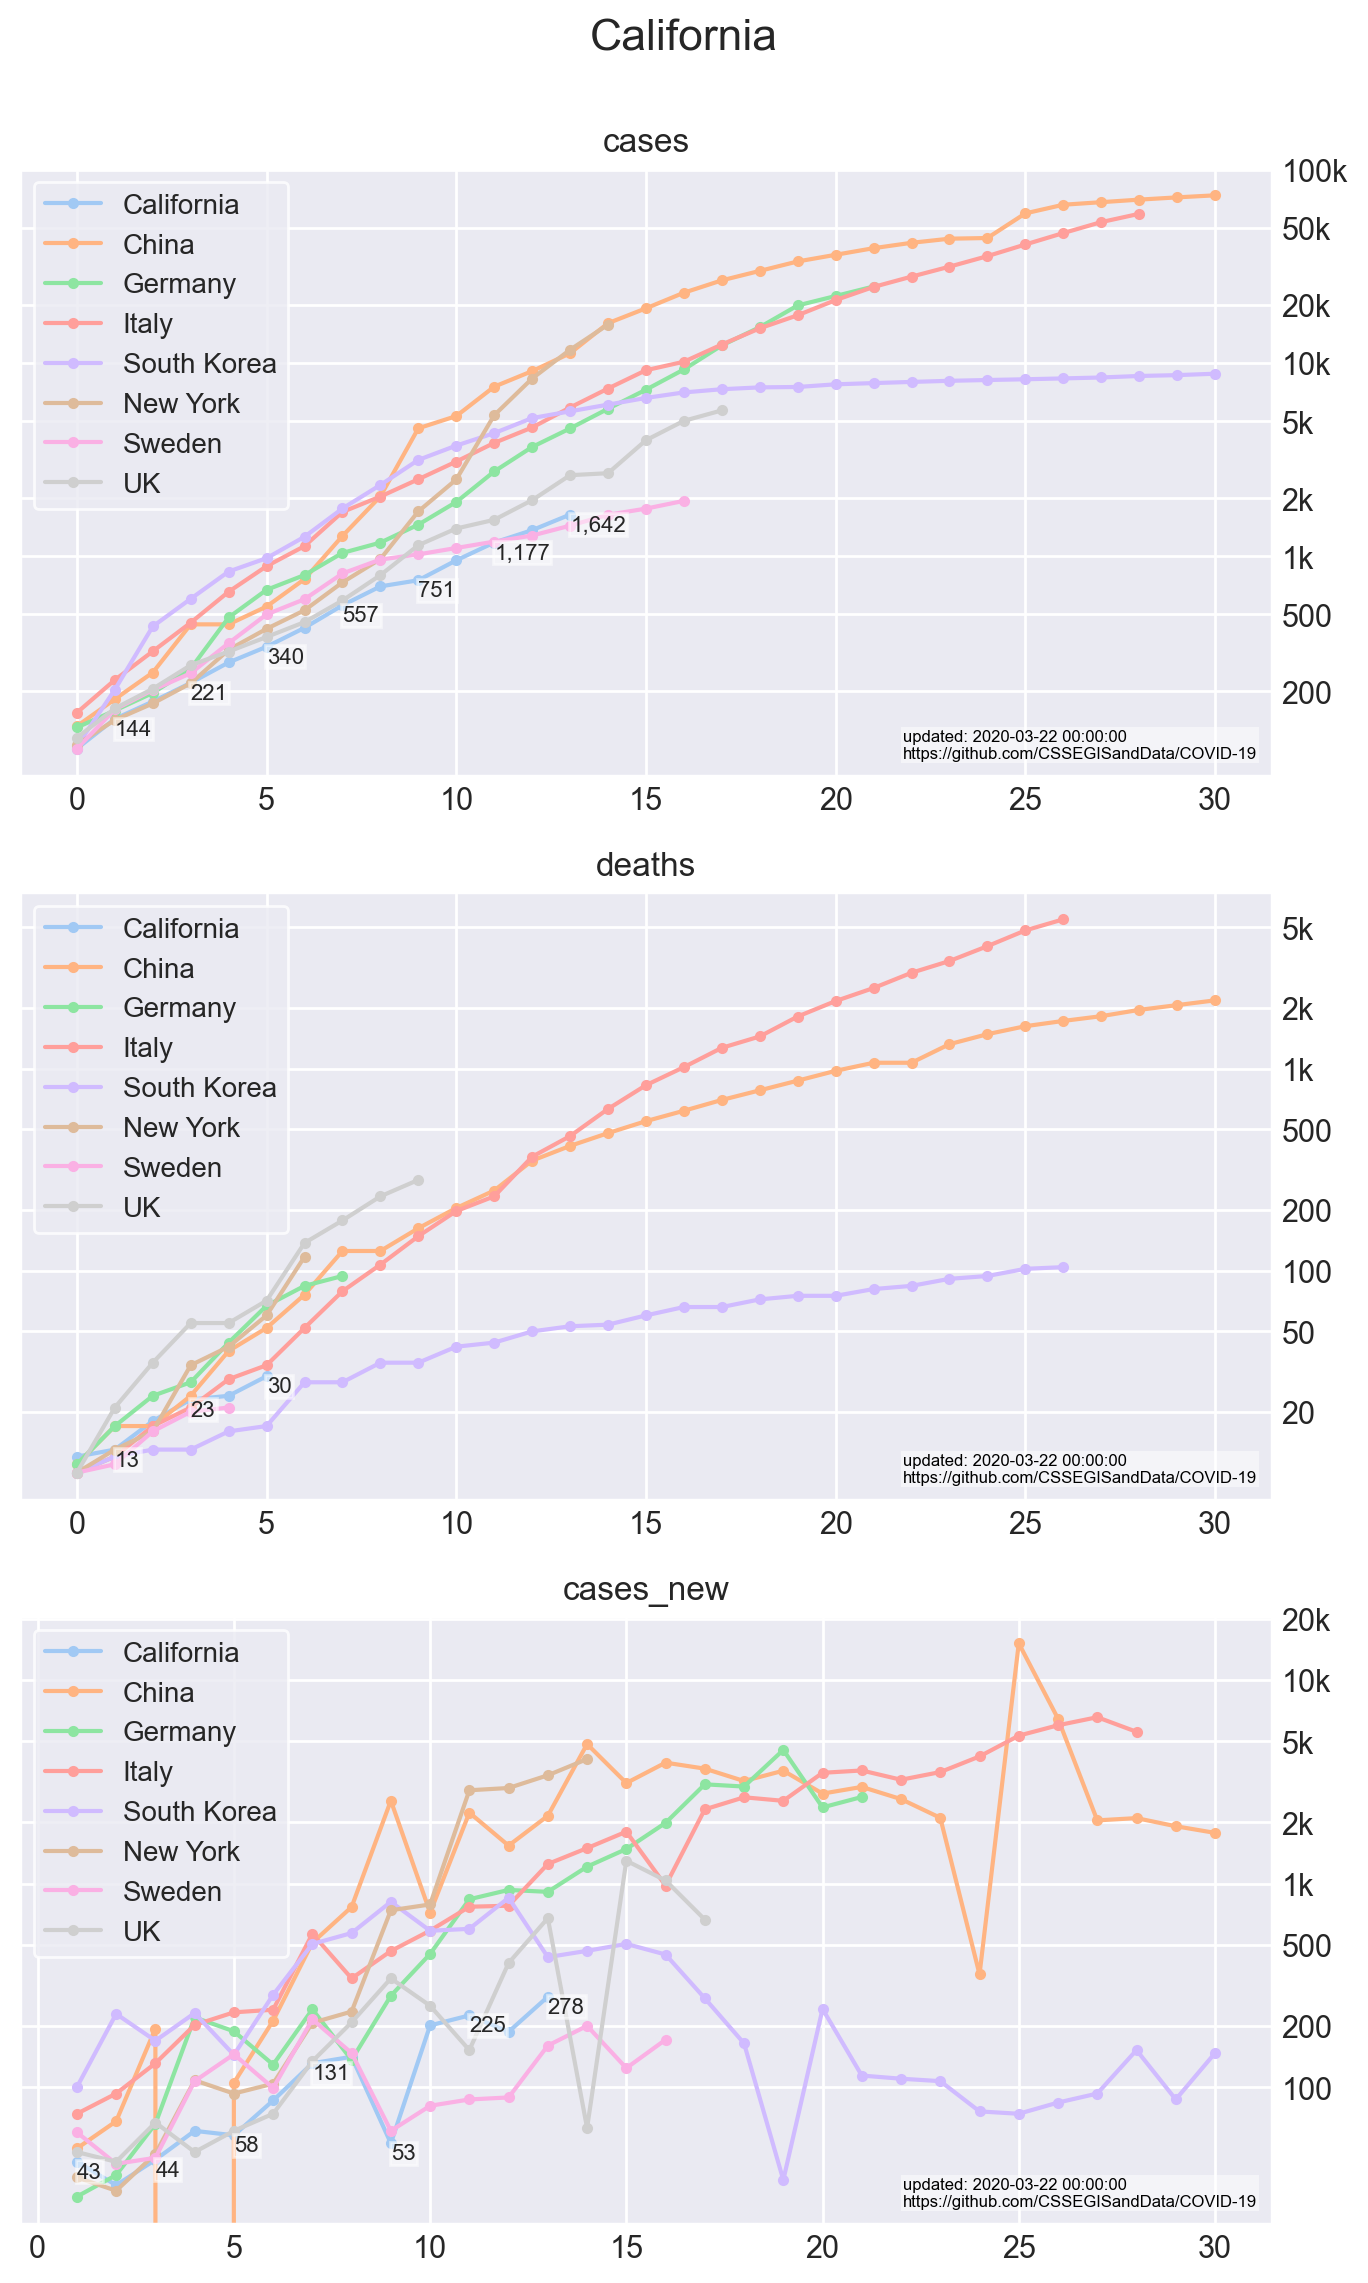

In [13]:
def get_timeseries(df, index, series, country=None, state=None, rollup_states=True):
    
    COLS = ['date', 'day', 'country', 'state', *METRICS]
    
    def reset_series(df):
        return df[COLS]
    
    def rollup_country(df):
        return (
            df
            .groupby(['date', 'day', 'country'])
            .agg({
                'cases': sum,
                'deaths': sum,
                'recovered': sum,
            })
            .reset_index()
            .assign(state=lambda df: df['country'])
            .pipe(reset_series)
        )
    
    df = df.copy()
    if 'metric' in df.columns:
        df = df.loc[df['metric'] == index]
    df = reset_series(df)

    if isinstance(country, str):
        country = [country]
    if isinstance(state, str):
        state = [state]

    df_country = df.loc[df['country'].isin(country)] if country else pd.DataFrame()
    df_state = df.loc[df['state'].isin(state)] if state else pd.DataFrame()

    if country and rollup_states:
        df_country = df_country.pipe(rollup_country)

    df = (
        pd
        .concat([df_country, df_state], sort=True)
        .pipe(with_offset, index, LIMITS[index])
        .pipe(reindex_offset, f"{index}_offset")
        .pipe(with_cases_active)
        .pipe(with_cfr)
        .pipe(with_diff)
        .pipe(with_pct_change)
    )

    df['region'] = df['state'].fillna(df['country'])
    df = df.pivot(index='offset', columns='region', values=series)
    return df


def plot(countries, states, df, plots, highlight='Italy', dpi=100):
    
    days = 31
    from_date = (dt.datetime.now() - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    
    rows = len(plots)
    fig, axs = plt.subplots(rows, 1, figsize=(7, rows * 4), dpi=dpi, facecolor='white')
    
    for i, t in enumerate(plots.items()):
        series, index = t
        ax = axs[i] if rows > 1 else axs

        ts = get_timeseries(
            df,
            index=index,
            series=series,
            country=countries,
            state=states
        )[:days]

        ts = ts.rename(columns={
            "United Kingdom": "UK",
            "Korea, South": "South Korea",
        })

        ts.plot(title=series, marker='.', ax=ax)
        
        # y-axis
        ax.set_yscale('log', basey=10)
        configure_yaxis(ax)
        ax.yaxis.tick_right()
        ax.tick_params(axis='both', which='both',length=0)

        # x-axis
        ax.xaxis.label.set_visible(False)
        ax.set_xticks(range(0, days, 5))
        
        # value labels
        values = ts[highlight].values
        for i, v in enumerate(values):
            # every 2 label, ensuring most recent value included
            op = operator.eq if dt.datetime.now().day else operator.ne
            if op(i % 2, len(values) % 2) & (v > 0):
                frmt = f'{v:,.1f}' if series in ['cfr'] else f'{v:,.0f}'
                bbox = dict(pad=0.5, facecolor='white', alpha=0.5)
                ax.text(i, v, frmt, ha='left', va='top', fontsize=8, bbox=bbox)

        # info text box
        text = f"updated: {CATALOG['csse']['timestamp']}\n{CATALOG['csse']['url']}"
        props = dict(color='black', fontsize=6)
        box = AnchoredText(text, loc=4, frameon=True, pad=0.1, borderpad=0.8, prop=props)
        plt.setp(box.patch, facecolor='white', alpha=0.5, linewidth=0)
        ax.add_artist(box)
        
        # legend
        plt.sca(ax)
        leg = plt.legend(loc=2, prop={'size':10})
        leg.get_frame().set_edgecolor('white')
        leg.get_frame().set_linewidth(1.0)

    if rows > 1:
        fig.suptitle(highlight, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        

df = CATALOG['ontology']['data']['metrics_by_offset'].copy()

plot(
    countries=eu5[:3] + nordics[:1] + asia[:2],
    states=us[:2],
    df=df,
    plots={
        'cases': 'cases',
        'deaths': 'deaths',
        'cases_new': 'cases',
    },
    **dict(highlight='California', dpi=200),
)